### Mass segregation

Analysis of the mass segregation in the stellar clusters using different indices <br>
In particular we use the MST-based metric (e.g. Yu et al. 2011)

In [42]:
using PyCall
using Distributions, Distances
using Statistics
using DataFrames
using LightGraphs, SimpleWeightedGraphs
using Random , Printf, Glob
using ConcaveHull

rootdir = ENV["GAIA_ROOT"]

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

import PyPlot , CSV , Distances

@pyimport astroquery.vizier as vizier
@pyimport astropy.units as u
@pyimport astropy.coordinates as coord


## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"
ocdir= "$wdir/oc"

cd(wdir)

In [43]:
## Test OC
##

#oc= CSV.read("$ocdir/NGC 6124-2.3deg-oc.csv" , delim= ";")
oc= CSV.read("$ocdir/NGC 7086-1.0deg-oc.csv", delim= ";")

## Mass Segregation type: 2d/3d
DTYPE="2d"

"2d"

In [44]:
## Create a graph with the selected stars
## ind: subset to select the x,y
## dtyp= "2d" or "3d"

function _mst_graph(ind,x,y,z=[] , dtyp="2d")
    nxy= length(ind)
    if dtyp == "2d"
        A= Array{Float64}(undef,2,nxy)
    elseif dtyp == "3d"
       A= Array{Float64}(undef,3,nxy) 
    end
    
    for i in 1:nxy
        if dtyp == "2d"
            A[:,i]= [x[ind[i]] y[ind[i]]]
        elseif dtyp == "3d"
            A[:,i]= [x[ind[i]] y[ind[i]] z[ind[i]]]
        end
    end
    
    d= Euclidean()
    p= pairwise(d, A, A, dims=2)
    #println(p)
    
    src= Array{Int}(undef,0)
    dst= Array{Int}(undef,0)
    wgt= Array{Float64}(undef,0)

    for i in 1:nxy
        for j in 1:nxy
            if i != j
                push!(src,i)
                push!(dst,j)
                push!(wgt,p[i,j]) 
            end
        end
    end
    
    G= SimpleWeightedGraph(src, dst, wgt)
    
    kr= kruskal_mst(G, G.weights)
    
    #for w in kr
    #    @printf("%d - %d : %3.3f\n",w.src,w.dst, w.weight)
    #end
    
    return(kr)
end


_mst_graph (generic function with 3 methods)

In [45]:
## Computation of the λMST using either arithmetic or geometric average (Olczak et al. 2011)
##
## dtype= "ari" or "geo"
function _lambda_mst(edges, dtyp="ari")
    nedg= length(edges)
    # println(nedg)
    ltot= 0
    
    for w in edges
        if dtyp== "ari"
            ltot+= w.weight
        elseif dtyp== "geo"
            ltot+= log(w.weight)
        end
    end
    
    if dtyp== "ari"
        λmst= ltot/nedg
    elseif dtyp== "geo"
        λmst= exp(ltot/nedg)
    end
    return(λmst)
end

## estimate the sample size for the stats given n and N for the massive and total sample
## p= 99%
## Olczak et al. 2011)
function _sample_size(n, N, p=0.99)
    k= log(1-p)/log(1-n/N)
    return(convert(Int,ceil(k)))
end

## Compute the mass segregation metric comparing two population set (2nd is random)
##
## nrandom: number of random set (default=1)
##
function _kappa_ms(indMass, x, y , z, nrandom=1, dtyp="2d", daver= "geo")
    npop= length(indMass)
    ntot= length(x)
    
    ## Massive stars
    krMass= _mst_graph(indMass, x,y,z , dtyp)
    λMass= _lambda_mst(krMass,daver)
    ## Random set
    λArr= []
    κArr= []
    for i in 1:nrandom
        perm= randperm(ntot)
        indRef= perm[1:npop]
        krRef= _mst_graph(indRef, x,y,z, dtyp)
        λRef= _lambda_mst(krRef,daver)
        push!(λArr,λRef)
        push!(κArr, log(λRef/λMass))
    end
    λMean= mean(λArr)
    σκ= std(κArr)
    ## ratio (log) of the reference over massive ones
    κms= log(λMean/λMass)
    
    return(κms , σκ)
end

_kappa_ms (generic function with 4 methods)

In [46]:
## Select the N percentile most massive stars (brighter)
##

function _select_massivestars(mag, percentile=5 , reverse=false)
    nstar= length(mag)
    isort= sortperm(mag, rev=reverse)
    
    nselect= convert(Int, floor(nstar*percentile/100))
    return(isort[1:nselect])
end


## return the MS kappa and kappa_err
## IN
## mag: magnitude array
## X,Y,Z: positions array
## perc: percentile of massive stars
## dtyp: "3d" or "2d"
## daver: "geo" or "ari"
## reverse: false:massive, true:light - stars

function _get_kappaMS(mag, X, Y, Z, perc, dtyp="3d", daver="geo", reverse=false)
    imass= _select_massivestars(mag, perc, reverse)
    ns= _sample_size(length(imass), length(X))
    κms, κms_err= _kappa_ms(imass, X, Y, Z, ns, dtyp, daver)
    return(κms, κms_err)
end

_get_kappaMS (generic function with 4 methods)

In [47]:
## Compute the Q ratio structure to measure the clustering of the OC.
## See Cartwright et al. (2004)
## directly adapted to 3D
##

### !!!!!!! Normalization to be checked on λ , Cartwright & 2004
### See as well Schmeja & Klessen 2006
### See version _get_Qnorm

function _get_Q(X, Y , Z)
    nxyz= length(X)
    A= Array{Float64}(undef,3,nxyz) 
    
    for i in 1:nxyz
            A[:,i]= [X[i] Y[i] Z[i]]
    end
    
    d= Euclidean()
    p= pairwise(d, A, A, dims=2)
    
    src= Array{Int}(undef,0)
    dst= Array{Int}(undef,0)
    wgt= Array{Float64}(undef,0)

    for i in 1:nxyz
        for j in 1:nxyz
            if i != j
                push!(src,i)
                push!(dst,j)
                push!(wgt,p[i,j]) 
            end
        end
    end
    
    G= SimpleWeightedGraph(src, dst, wgt)
    kr= kruskal_mst(G, G.weights)
    
    ## compute the mean (arithmtic) edge of MST and of star separation. We do not apply other normalization
    λmst= 0
    for w in kr
        λmst+= w.weight
    end
    
    V= _get_volume(X,Y,Z)
    k= (V / nxyz )^(1/3)
    λmst /= k*length(kr)
    
    npair= nxyz*(nxyz-1)/2
    radius= (V * 3 / (4 * π))^(1/3)
    sbar= sum(p) / npair / radius
    
    Q= λmst / sbar
end

##############
## normalized version
##
function _get_Qnorm(X, Y , Z , rad=1 , dim=3)
    nxyz= length(X)
    A= Array{Float64}(undef,3,nxyz) 
    
    for i in 1:nxyz
            A[:,i]= [X[i] Y[i] Z[i]]
    end
    
    d= Euclidean()
    p= pairwise(d, A, A, dims=2)
    
    src= Array{Int}(undef,0)
    dst= Array{Int}(undef,0)
    wgt= Array{Float64}(undef,0)

    for i in 1:nxyz
        for j in 1:nxyz
            if i != j
                push!(src,i)
                push!(dst,j)
                push!(wgt,p[i,j]) 
            end
        end
    end
    
    G= SimpleWeightedGraph(src, dst, wgt)
    kr= kruskal_mst(G, G.weights)
        
    ## compute the mean (arithmtic) edge of MST and of star separation. We do not apply other normalization
    λmst= 0
    for w in kr
        λmst+= w.weight
    end
    
    V= _get_volume(X,Y,Z)
    k= (V / nxyz )^(1/3)
    λmst /= k*length(kr)
    
    npair= nxyz*(nxyz-1)/2
    knorm= (4 /3 * π * rad^3 / nxyz)^(1/3)
    sbar= sum(p) / npair / knorm
    
    Q= λmst / sbar
    return(Q)
end

## Get the volume V enclosing the points X,Y,Z
###
function _get_volume(X,Y,Z)
    xg= mean(X) ; yg= mean(Y) ; zg= mean(Z)
    center= [xg;yg;zg]
    
    nxyz= length(X)
    A= Array{Float64}(undef,3,nxyz)
    for i in 1:nxyz
        A[1,i]= X[i]
        A[2,i]= Y[i]
        A[3,i]= Z[i]
    end
    
    d= Distances.Euclidean()
    r= Distances.colwise(d, A, center)
    radius= maximum(r)
    vol= (4/3)*π*radius^3 
    return(vol)
end

_get_volume (generic function with 1 method)

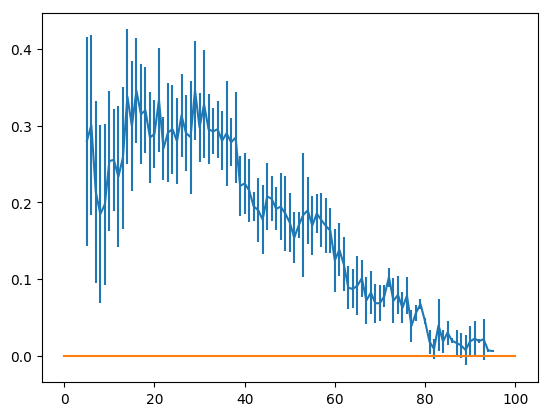

0.31544306621571144
0.08816209331304216


In [48]:
## Main

# kr= _mst_graph([1,5,10,16,20,27,30], oc[:X], oc[:Y] , oc[:Z] , "2d")
#  _lambda_mst(kr,"geo")


imass= _select_massivestars(oc[:gbar], 15)
ns= _sample_size(length(imass), length(oc[:X]))
y, yerr= _kappa_ms( imass, oc[:X], oc[:Y] , oc[:Z], ns, DTYPE, "geo")
println(y)
println(yerr)


## plots..

percentile=[]
Κms= []
errΚms= []

for perc in 5:95
    push!(percentile, perc)
     imass= _select_massivestars(oc[:gbar], perc, false)
    ns= _sample_size(length(imass), length(oc[:X]))
    y, yerr= _kappa_ms( imass, oc[:X], oc[:Y] , oc[:Z], ns, DTYPE , "geo")
    push!(Κms, y)
    push!(errΚms, yerr)   
end


PyPlot.errorbar(percentile, Κms, yerr=errΚms)
PyPlot.plot([0,100],[0,0])
PyPlot.show()

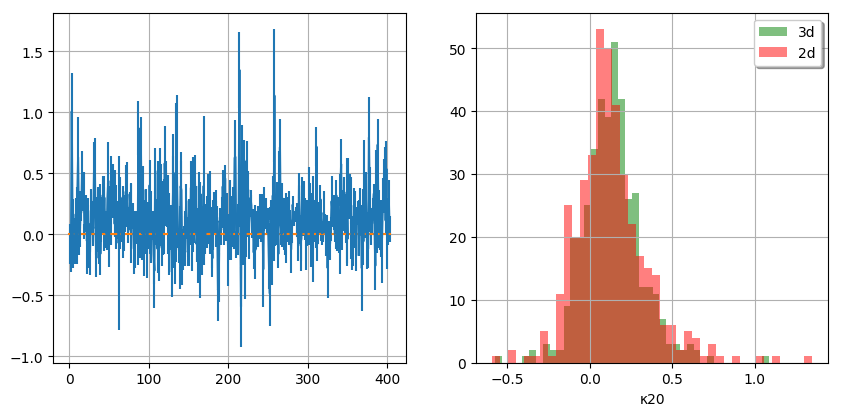

0.1294234935260796
0.2243508151646303
0.1346226146108482
0.17902517716248523


In [49]:
## Loop over all OCs

cd(ocdir)
files= glob("*csv")
cd(wdir)

percms= 10
ilabel= []
Κms2d= [] ; Κms3d = []
errΚms2d= [] ; errΚms3d= []
i= 0
for f in files
    i+= 1
    oc= CSV.read("$ocdir/$f" , delim= ";")
    # imass= _select_massivestars(oc[:gbar], percms)
    # ns= _sample_size(length(imass), length(oc[:X]))
    # y, yerr= _kappa_ms( imass, oc[:X], oc[:Y] , oc[:Z], ns, "3d", "geo")
    y, yerr= _get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], percms, "3d", "geo", false)
    push!(ilabel, i)
    push!(Κms3d, y)
    push!(errΚms3d, yerr)  
    
    y, yerr= _get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], percms, "2d", "geo", false)
    push!(Κms2d, y)
    push!(errΚms2d, yerr) 
    
end

println(mean(Κms2d))
println(std(Κms2d))
println(mean(Κms3d))
println(std(Κms3d))

fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.errorbar(ilabel, Κms2d, yerr=errΚms2d)
PyPlot.plot([0,length(ilabel)],[0,0])

ax= PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.xlabel("κ20")
PyPlot.hist(Κms3d , 40, density=false, facecolor="g", alpha= 0.5, label= "3d")
PyPlot.hist(Κms2d , 40, density=false, facecolor="r", alpha= 0.5 , label= "2d")
PyPlot.legend(loc="upper right", shadow=true)

PyPlot.show()

In [50]:
### Q structure factor
_get_Q(oc[:X], oc[:Y] , oc[:Z])

0.3098679098576276

In [51]:
## looping on all OCs to compute MS and Q
##
ocage= CSV.read("votlist.finalSample_metric0.01-age.csv", delim=";")

t1= Array{Float64,1}(undef,0) ; t2= Array{Float64,1}(undef,0) ; t3= Array{Float64,1}(undef,0)
t4= Array{Float64,1}(undef,0) ; t5= Array{Float64,1}(undef,0) ; t6= Array{Float64,1}(undef,0)

t7= Array{Float64,1}(undef,0) ; t8= Array{Float64,1}(undef,0) ; t9= Array{Float64,1}(undef,0)
t10= Array{Float64,1}(undef,0) ; t11= Array{Float64,1}(undef,0) ; t12= Array{Float64,1}(undef,0)
t13= Array{Float64,1}(undef,0) 

for vot in ocage[:votname]
    ocfile= @sprintf("%s/%s-oc.csv", ocdir, vot[1:end-4])
    oc= CSV.read(ocfile, delim= ";")
    
    κ10, κ10_err= get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], 10, DTYPE, "geo", false)
    κ15, κ15_err= get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], 15, DTYPE, "geo", false)
    κ20, κ20_err= get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], 20, DTYPE, "geo", false)
    κlight10, κlight10_err= _get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], 10, DTYPE, "geo", true)
    κlight15, κlight15_err= _get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], 15, DTYPE, "geo", true)
    κlight20, κlight20_err= _get_kappaMS(oc[:gbar],oc[:X], oc[:Y] , oc[:Z], 20, DTYPE, "geo", true)
    Q= get_Q(oc[:X], oc[:Y] , oc[:Z])
    
    push!(t1, κ10) ; push!(t2, κ10_err)  ; push!(t3, κ15) ; push!(t4, κ15_err)  
    push!(t5, κ20) ; push!(t6, κ20_err)
    push!(t7, κlight10) ; push!(t8, κlight10_err)  ; push!(t9, κlight15) ; push!(t10, κlight15_err)  
    push!(t11, κlight20) ; push!(t12, κlight20_err) 
    push!(t13, Q)
end

ocage.kappa10= t1 ; ocage.kappa10err= t2 ; ocage.kappa15= t3 ; ocage.kappa15err= t4
ocage.kappa20= t5 ; ocage.kappa20err= t6
ocage.kappalight10= t7 ; ocage.kappalight10err= t8 ; ocage.kappalight15= t9 ; ocage.kappalight15err= t10
ocage.kappalight20= t11 ; ocage.kappalight20err= t12
ocage.Q= t13

CSV.write("votlist.finalSample_metric0.01-age.MS.csv", ocage, delim=";")

"votlist.finalSample_metric0.01-age.MS.csv"

In [52]:
## print kappa

df1= ocage[:, [:votname,:kappa20]]
print(sort(df1,[:kappa20]))

403×2 DataFrame
│ Row │ votname                    │ kappa20      │
│     │ Union{Missing, String}     │ Float64      │
├─────┼────────────────────────────┼──────────────┤
│ 1   │ Patchick 75-1.0deg.vot     │ -0.258557    │
│ 2   │ NGC 2129-1.0deg.vot        │ -0.253087    │
│ 3   │ FSR 1163-1.0deg.vot        │ -0.223556    │
│ 4   │ FSR 1703-1.0deg.vot        │ -0.19629     │
│ 5   │ FSR 1200-1.0deg.vot        │ -0.185178    │
│ 6   │ ESO 313-12-1.0deg.vot      │ -0.184114    │
│ 7   │ FSR 1199-1.0deg.vot        │ -0.181616    │
│ 8   │ FSR 1379-1.0deg.vot        │ -0.175439    │
│ 9   │ Lynga 4-1.0deg.vot         │ -0.171779    │
│ 10  │ FSR 1460-1.0deg.vot        │ -0.153476    │
│ 11  │ Ruprecht 96-1.0deg.vot     │ -0.148299    │
│ 12  │ FSR 1160-1.0deg.vot        │ -0.145773    │
│ 13  │ Loden 615-1.2deg.vot       │ -0.143575    │
│ 14  │ FSR 1468-1.0deg.vot        │ -0.141638    │
│ 15  │ ASCC 60-1.0deg.vot         │ -0.129027    │
│ 16  │ ASCC 120-1.1deg.vot        │ -0.126618  

│ 166 │ NGC 6167-1.1deg.vot        │ 0.0783639    │
│ 167 │ Hogg 6-1.0deg.vot          │ 0.0788019    │
│ 168 │ Hogg 20-1.0deg.vot         │ 0.0794205    │
│ 169 │ ASCC 100-1.8deg.vot        │ 0.0794374    │
│ 170 │ Czernik 44-1.0deg.vot      │ 0.0805279    │
│ 171 │ Platais 5-10.3deg.vot      │ 0.0820667    │
│ 172 │ NGC 3114-1.7deg.vot        │ 0.0826116    │
│ 173 │ Berkeley 14A-2.3deg.vot    │ 0.0832217    │
│ 174 │ NGC 1912-2.0deg.vot        │ 0.0832941    │
│ 175 │ FSR 0442-1.0deg.vot        │ 0.0836162    │
│ 176 │ NGC 3532-2.1deg.vot        │ 0.0846629    │
│ 177 │ Collinder 463-2.5deg.vot   │ 0.0851927    │
│ 178 │ Dolidze 11-1.0deg.vot      │ 0.0855194    │
│ 179 │ MWSC 5309-1.0deg.vot       │ 0.0861302    │
│ 180 │ ASCC 118-1.0deg.vot        │ 0.0862298    │
│ 181 │ NGC 4852-1.0deg.vot        │ 0.0865596    │
│ 182 │ NGC 2682-5.2deg.vot        │ 0.0865934    │
│ 183 │ Collinder 421-1.1deg.vot   │ 0.0893076    │
│ 184 │ NGC 2175-1.0deg.vot        │ 0.0893144    │
│ 185 │ NGC 

│ 351 │ NGC 6991A-2.2deg.vot       │ 0.280246     │
│ 352 │ Collinder 197-1.1deg.vot   │ 0.287569     │
│ 353 │ Berkeley 55-1.0deg.vot     │ 0.294699     │
│ 354 │ FSR 1443-1.0deg.vot        │ 0.296227     │
│ 355 │ Czernik 8-1.0deg.vot       │ 0.300407     │
│ 356 │ FSR 0398-1.1deg.vot        │ 0.304084     │
│ 357 │ NGC 2632-15.5deg.vot       │ 0.306001     │
│ 358 │ IC 2395-1.2deg.vot         │ 0.308549     │
│ 359 │ BDSB 21-1.0deg.vot         │ 0.309287     │
│ 360 │ Alessi 20-1.5deg.vot       │ 0.30966      │
│ 361 │ Ruprecht 147-6.7deg.vot    │ 0.311006     │
│ 362 │ NGC 7086-1.0deg.vot        │ 0.311537     │
│ 363 │ Ruprecht 65-1.0deg.vot     │ 0.313076     │
│ 364 │ NGC 381-1.0deg.vot         │ 0.322614     │
│ 365 │ IC 2602-6.0deg.vot         │ 0.32567      │
│ 366 │ FSR 1411-1.0deg.vot        │ 0.325682     │
│ 367 │ Pismis 19-1.0deg.vot       │ 0.326628     │
│ 368 │ Lynga 2-1.0deg.vot         │ 0.326967     │
│ 369 │ FSR 1144-1.0deg.vot        │ 0.3394       │
│ 370 │ Czer

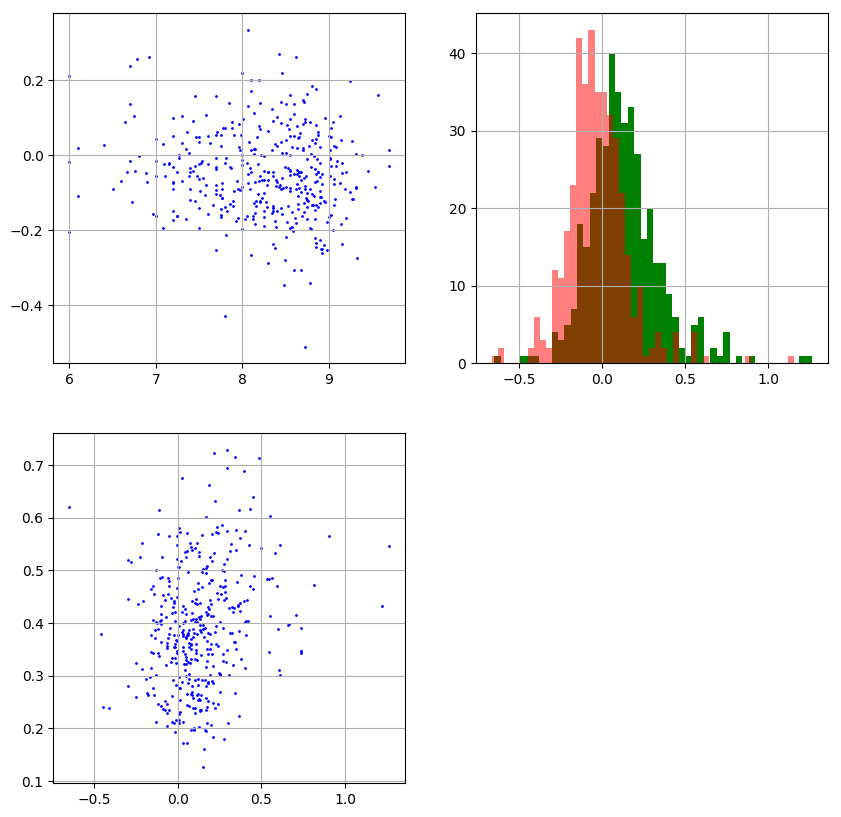

In [53]:
fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.scatter(ocage[:log_age],ocage[:kappalight20] , s=1, facecolor="blue")

ax= PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.hist(ocage[:kappa10] , 50, density=false, facecolor="g")
PyPlot.hist(ocage[:kappalight10] , 50, density=false, facecolor="r", alpha=0.5 )

ax= PyPlot.subplot(223)
PyPlot.grid("on")
PyPlot.scatter(ocage[:kappa10],ocage[:Q] , s=1, facecolor="blue")
PyPlot.show()

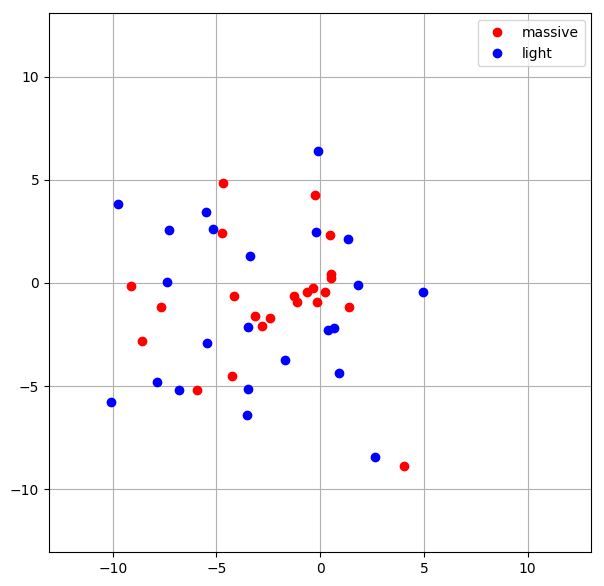

In [83]:
## Example of star distribution in an OC

ocname= "NGC 2547-1.5deg"
ocname= "NGC 2516-3.5deg"
ocname= "NGC 1901-1.7deg"
oc= CSV.read("$ocdir/$ocname-oc.csv", delim= ";")
perc= 20

imass= _select_massivestars(oc.gbar, perc, false)
ilight= _select_massivestars(oc.gbar, perc, true)

fig= PyPlot.figure(figsize=(7,7))

ax= PyPlot.subplot(111)
PyPlot.grid("on")

lmax= max(maximum(oc.Y),maximum(oc.Z))
PyPlot.xlim([-lmax,lmax])
PyPlot.ylim([-lmax,lmax])
PyPlot.plt.plot(oc.Y[imass], oc.Z[imass],"or",label="massive")
PyPlot.plt.plot(oc.Y[ilight], oc.Z[ilight],"ob",label="light")
PyPlot.legend()

PyPlot.show()
